In [20]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time
import random
import scipy.stats as stats


In [21]:

# # with open('../data/foods.txt', 'r') as file:
#     # Read all the content of the file
#     # file_content = file.read()

# reviews=[]

# # Open the file and read the first 200 lines
# with open('../data/foods.txt', 'r', encoding='utf-8', errors='ignore') as file:
#     # Use list comprehension to read the first 200 lines
#     first_200_lines = np.array([next(file) for _ in range(2000)])
#     print(first_200_lines)

#     score_cells = [entry for entry in first_200_lines if re.search(r'^review/score:', entry, re.MULTILINE)]

#     # Print the matching cells
#     for cell in score_cells:
        
#         reviews.append(float(cell[-4:-1]))



In [22]:
# handige functies voor gaandeweg
def shrinkage_operator(x, phi):
    # Apply the shrinkage (soft-thresholding) operator element-wise
    return np.where(x > phi, x - phi, np.where(x < -phi, x + phi, 0))


def soft_threshold(x, threshold):
    """Soft-thresholding operator"""
    return np.where(x > threshold, x - threshold,
                    np.where(x < -threshold, x + threshold, 0))

In [23]:
def orthogonal_projection(x, t):
    # In de paper weergegeven als P_K 
    norm_x = np.linalg.norm(x)  # Frobenius norm for the vector x
    if norm_x <= t:
        return np.array([x, t])
    elif -norm_x <= t <= norm_x:
        scale = (norm_x + t) / (2 * norm_x)
        return np.array([scale * x, scale * norm_x])
    else:
        return np.array([0, 0])

def projection_onto_soc(x, t):
    """Project onto the second-order cone K"""
    x_norm = np.linalg.norm(x)

    if x_norm <= t:
        return x,t  # Case 1: x_F ≤ t
    elif -x_norm <= t <= x_norm:
        # Case 2: -x_F ≤ t ≤ x_F
        projected_x = 1/2 * (1 + t / x_norm) * x  # Scale the vector x
        projected_t = (x_norm + t) / 2  # Update t
        return projected_x, projected_t  # Return as separate entities
    else:
        return np.zeros_like(x), 0  # Case 3: t ≤ -x_F


In [24]:
def error(P, R):
    re_er = 0.5 * np.linalg.norm((P-R), 'fro')**2
    data_norm_squared = np.linalg.norm(R, 'fro')**2
    objective_percentage = (re_er / data_norm_squared) * 100
    return objective_percentage

def validationErrors(P, R, num_tested_ratings):
    MAE = np.sum(np.abs(R-P))/num_tested_ratings
    RMSE = np.sqrt(np.sum(np.abs(R-P)**2)/num_tested_ratings)
    return MAE, RMSE


def matrix_rank(M, tol=1e-6):
    """Rank check function"""
    _, Sigma, _ = np.linalg.svd(M, full_matrices=False)
    return np.sum(Sigma > tol)


def generate_matrix_with_rank(m, n, r):
    assert r <= min(m, n), "Rank r must be less than or equal to the smaller of m or n."
    
    # Generate two random matrices of size m x r and r x n
    A = np.random.rand(m, r)
    B = np.random.rand(r, n)
    
    # Multiply A and B to get a matrix of size m x n with rank r
    matrix = np.dot(A, B)
    
    return matrix

In [25]:


def proximal_operator_P(y, R, u, rho):
    """Proximal operator for P"""
    S = y / rho + R - u
    Q, Sigma, W = np.linalg.svd(S, full_matrices=False)
    Sigma_prox = soft_threshold(Sigma, 1/rho)
    rank = np.sum(Sigma_prox > 0)
    P_next = Q[:, :rank] * Sigma_prox[:rank] @ W[:rank, :]
    return P_next, rank


def update_y_s(y, s, P, R, delta, epsilon):
    """Update Lagrange multipliers y and s using projection onto the second-order cone K."""
    # P must be the P_{k+1} and not the P_k
    difference = R - P
    y_new, s_new = projection_onto_soc(y + delta * difference, s - delta*epsilon)
    return y_new, s_new



def proximal_operator_Z(P, u, lambda_, rho):
    """Proximal operator for auxiliary variable Z"""
    # P is the new P_k+1
    # u is the u_k 
    Z_next = soft_threshold(P + u, lambda_ / rho)
    return Z_next


In [26]:
def optimize(rho, lambda_, R, P_init, u_init, y_init, s_init, delta, epsilon, num_iterations):
    """Main optimization loop."""
    P = P_init
    u = u_init
    y = y_init
    s = s_init
    Z = np.zeros_like(P) 
    errors = []
    

    for k in range(num_iterations):

        P, rank_P = proximal_operator_P(y, R, u, rho)

        y, s = update_y_s(y, s, P, R, delta, epsilon)

        Z = proximal_operator_Z(P, u, lambda_, rho)

        u = u + (P - Z)
        
        print(f"Iteration {k+1}: Rank of P = {rank_P}")

        MAE, RMSE = validationErrors(P, R, R.shape[0]*R.shape[1])
        errors.append([MAE, RMSE])

    return P, Z, u, y, s, errors


In [27]:
reviews = np.array(reviews)
reviews.shape

(0,)

In [28]:
# now clip to remove all the low-intensity values
def clip_matrix(M, threshold=0.5):
    """
    Clips the values in matrix M, setting any value below the given threshold to 0.
    
    Args:
    - M (numpy array): The input matrix (values between 0 and 1).
    - threshold (float): The clipping threshold (default 0.5).
    
    Returns:
    - M_clipped (numpy array): A new matrix with values below the threshold set to 0.
    """
    # Ensure the input matrix is a numpy array
    M = np.array(M)
    
    # Clip values below the threshold by setting them to 0
    M_clipped = np.where(M < threshold, 0, M)
    
    return M_clipped




def probabilityMatrix(n_rows, n_cols, percentage):
    one_matrix = np.ones((n_rows, n_cols), dtype=int)
    num_cells = n_rows * n_cols
    num_zeros = int(percentage * num_cells)
    
    # Flatten the matrix to choose random indices
    flat_indices = np.random.choice(num_cells, num_zeros, replace=False)
    
    # Set these chosen indices to 0
    one_matrix.flat[flat_indices] = 0
    
    return one_matrix

def randomDiscard(M, ratio_keep):
    P = probabilityMatrix(M.shape[0], M.shape[1], ratio_keep)
    return np.multiply(M, P)


# now clip to remove all the low-intensity values
def clip_matrix(M, threshold=0.5):
    """
    Clips the values in matrix M, setting any value below the given threshold to 0.
    
    Args:
    - M (numpy array): The input matrix (values between 0 and 1).
    - threshold (float): The clipping threshold (default 0.5).
    
    Returns:
    - M_clipped (numpy array): A new matrix with values below the threshold set to 0.
    """
    # Ensure the input matrix is a numpy array
    M = np.array(M)
    
    # Clip values below the threshold by setting them to 0
    M_clipped = np.where(M < threshold, 0, M)
    
    return M_clipped



def generate_matrix_with_rank(m, n, r):
    assert r <= min(m, n), "Rank r must be less than or equal to the smaller of m or n."
    
    # Generate two random matrices of size m x r and r x n
    A = np.random.rand(m, r)
    B = np.random.rand(r, n)
    
    # Multiply A and B to get a matrix of size m x n with rank r
    matrix = np.dot(A, B)
    
    return matrix


def threshold_percentage(data, percentage):
    mu = np.mean(data)
    sigma = np.std(data)
    return mu + sigma * stats.norm.ppf(1-percentage)



In [29]:

def partlyDiscardedClipping(data_matrix, uniform_ratio_keep, threshold=None, threshold_ratio_keep=0.6):
    # Create a figure and axis for the original matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the matrix with a color scale
    cax = ax.matshow(data_matrix, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()
    
    # Randomly discard values to create an imperfect matrix
    imperfect_matrix = randomDiscard(data_matrix, 1 - uniform_ratio_keep)

    # Replace zeros in the imperfect matrix with NaN
    imperfect_matrix_with_nan = np.where(imperfect_matrix == 0, np.nan, imperfect_matrix)

    
    # Create a figure and axis for the imperfect matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the imperfect matrix with NaN values
    cax = ax.matshow(imperfect_matrix_with_nan, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()

    if threshold is None:
        threshold = threshold_percentage(data_matrix, threshold_ratio_keep)

    # Clip the imperfect matrix
    clipped_imperfect_matrix = clip_matrix(imperfect_matrix, threshold)

    # Replace zeros in the clipped matrix with NaN
    clipped_imperfect_matrix_with_nan = np.where(clipped_imperfect_matrix == 0, np.nan, clipped_imperfect_matrix)
    
    
    # Create a figure and axis for the clipped matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the clipped matrix with NaN values
    cax = ax.matshow(clipped_imperfect_matrix_with_nan, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()

    return clipped_imperfect_matrix


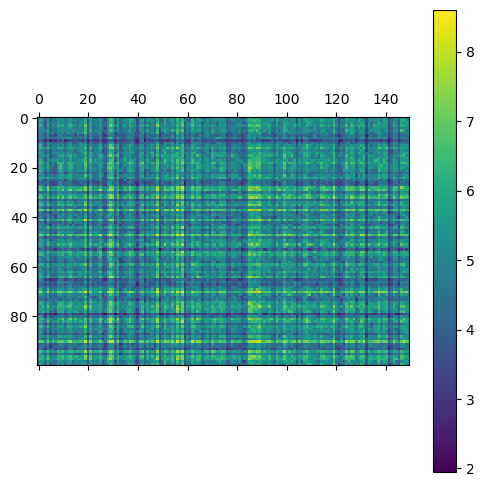

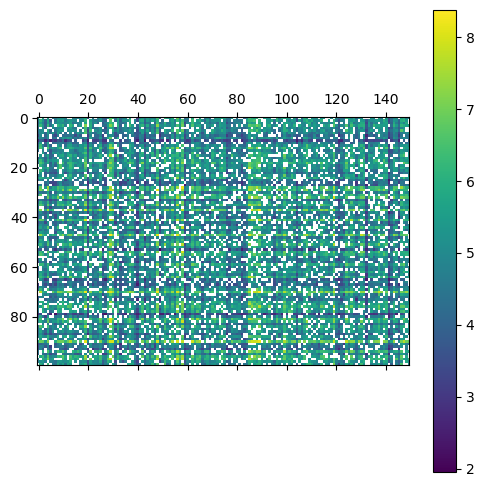

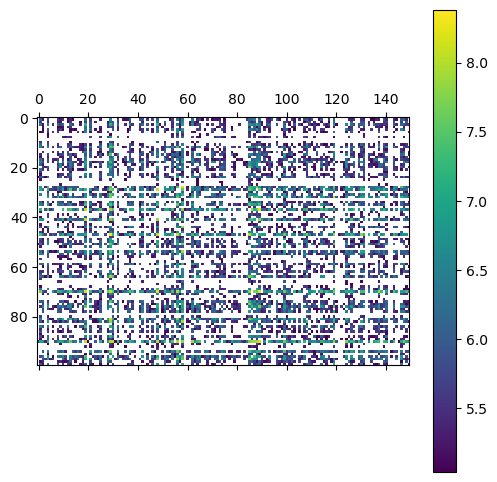

Iteration 1: Rank of P = 20
Iteration 2: Rank of P = 20
Iteration 3: Rank of P = 20
Iteration 4: Rank of P = 20
Iteration 5: Rank of P = 20
Iteration 6: Rank of P = 20
Iteration 7: Rank of P = 20
Iteration 8: Rank of P = 20
Iteration 9: Rank of P = 20
Iteration 10: Rank of P = 20
Iteration 11: Rank of P = 20
Iteration 12: Rank of P = 20
Iteration 13: Rank of P = 20
Iteration 14: Rank of P = 20
Iteration 15: Rank of P = 20
Iteration 16: Rank of P = 20
Iteration 17: Rank of P = 20
Iteration 18: Rank of P = 20
Iteration 19: Rank of P = 20
Iteration 20: Rank of P = 20
Iteration 21: Rank of P = 20
Iteration 22: Rank of P = 20
Iteration 23: Rank of P = 20
Iteration 24: Rank of P = 20
Iteration 25: Rank of P = 20
Iteration 26: Rank of P = 20
Iteration 27: Rank of P = 20
Iteration 28: Rank of P = 20
Iteration 29: Rank of P = 20
Iteration 30: Rank of P = 20
Iteration 31: Rank of P = 20
Iteration 32: Rank of P = 20
Iteration 33: Rank of P = 20
Iteration 34: Rank of P = 20
Iteration 35: Rank of P

In [33]:

m = 100
n = 150
r =20



R =generate_matrix_with_rank(m, n, r)
P_init = partlyDiscardedClipping(data_matrix=R, uniform_ratio_keep=0.8, threshold=None, threshold_ratio_keep=0.5)
u_init = np.zeros((m, n))
y_init = np.zeros((m, n)) 
s_init = 1 # ?
rho = 10000 # ? 
lambda_ = 0.4 #vanuit de grafiek als minimum bij de foods

delta = 1e-3 #convention?!?
num_iterations = 1000

# gamma γ = 0, 0.001 and 0.01. 
gamma = 0.01 #een van de 3 mogelijkheden
epsilon =m*n*gamma # uit de paper

P_final, Z_final, u_final, y_final, s_final, errors = optimize(rho, lambda_, R, P_init, u_init, y_init, s_init, delta, epsilon, num_iterations)

print("Final R:", R)
print("Final P:", P_final)
print("Final Z:", Z_final)
print("Final u:", u_final)
print("Final y:", y_final)
print("Final s:", s_final)

print("Error:", error(P_final, R))

S_1 = y_init / rho + R - u_init
Q, Sigma, W = np.linalg.svd(S_1, full_matrices=False)
# print(f"Singular values before thresholding: {Sigma}")
Sigma_prox = soft_threshold(Sigma, 1/rho)
# print(f"Singular values after thresholding: {Sigma_prox}")

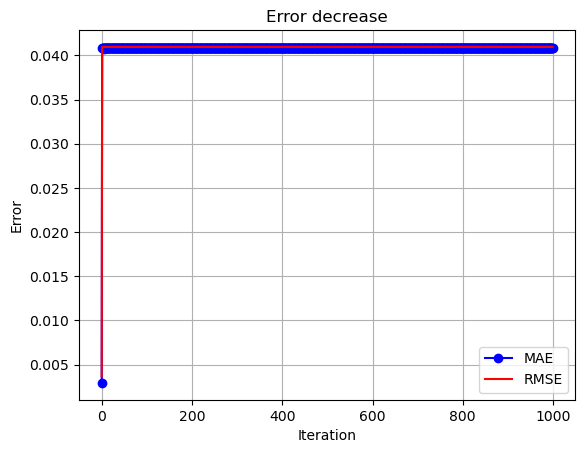

In [31]:
errors = np.array(errors)

# Create a plot
plt.figure()
plt.plot(errors[:,0], marker='o', linestyle='-', color='b', label='MAE')
plt.plot(errors[:,1], color='r', label='RMSE')

# Add labels and title
plt.title("Error decrease")
plt.xlabel("Iteration")
plt.ylabel("Error")

# Show legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()